In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

import ishneholterlib

from sak.signal import StandardHeader

def predict_mask(signal, model, window_size=2048, stride=256, thr_dice=0.9, ptg_voting = 0.25, batch_size = 16, use_tqdm=False, normalize=False):
    # Preprocess signal
    signal = np.copy(signal).squeeze()
    if signal.ndim == 0:
        return np.array([])
    elif signal.ndim == 1:
        signal = signal[:,None]
    elif signal.ndim == 2:
        if signal.shape[0] < signal.shape[1]:
            signal = signal.T
    else:
        raise ValueError("2 dims max allowed")
        
    # Get dimensions
    N,L = signal.shape
    
    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(signal,(window_size,1),(stride,1))
    
    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # (Optional) Normalize amplitudes
    if normalize:
        amplitude = np.median(
            sak.signal.moving_lambda(
                windowed_signal[:,0,:].T,
                256,
                partial(sak.signal.amplitude,axis=0)
            ),
            axis=0
        )
        amplitude[amplitude == 0] = 1.
        windowed_signal = windowed_signal/amplitude[:,None,None]
        

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=float)

    # Compute segmentation for all leads independently
    with torch.no_grad():
        iterator = range(0,windowed_signal.shape[0],batch_size)
        if use_tqdm: 
            iterator = tqdm.tqdm(iterator)
        for i in iterator:
            inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).cuda().float()}
            windowed_mask[i:i+batch_size] = model.cuda()(inputs)["sigmoid"].cpu().detach().numpy() > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((N), dtype=int)
    segmentation = np.zeros((3,N))
        
    # Iterate over windows
    for i in range(0,windowed_mask.shape[0],L):
        counter[(i//L)*stride:(i//L)*stride+window_size] += 1
        segmentation[:,(i//L)*stride:(i//L)*stride+window_size] += windowed_mask[i:i+L].sum(0)
    segmentation = ((segmentation/counter) >= (signal.shape[-1]*ptg_voting))

    return segmentation


# Load model

In [3]:
basedir = '/media/guille/DADES/DADES/Delineator/'
model_name = 'UNet7LevelsConvDiceOnly_20201203124825'
model_type = 'model_best'

#########################################################################
# Load models
models = {}
for i in range(5):
    if os.path.isfile(os.path.join(basedir,'TrainedModels',model_name,'fold_{}'.format(i+1),'{}.model'.format(model_type))):
        models['fold_{}'.format(i+1)] = torch.load(os.path.join(basedir,'TrainedModels',model_name,'fold_{}'.format(i+1),'{}.model'.format(model_type)),pickle_module=dill).eval().float()
    else:
        print("File for fold {} not found. Continuing...".format(i+1))


# Load ECG

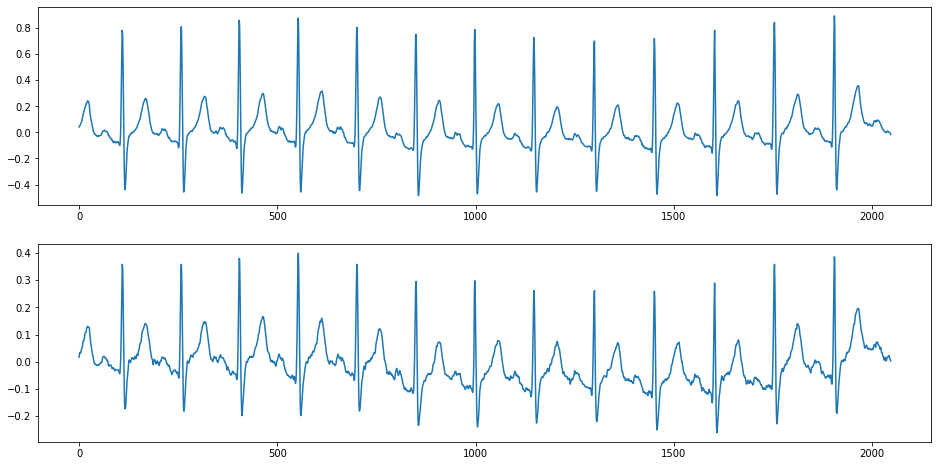

In [4]:
ecg = ishneholterlib.Holter('/home/guille/Descargas/sample_ecg_2channels_24hours (1).ecg')
ecg.load_data(convert=True)
signal = np.array([lead.data for lead in ecg.lead])

f,ax = plt.subplots(nrows=2,figsize=(16,8))

on = 120000
off = on + 2048

ax[0].plot(ecg.lead[0].data[on:off])
ax[1].plot(ecg.lead[1].data[on:off])

# Predict mask

In [70]:
# Normalize signal

# Obtain segmentation
segmentation = 0
for j,fold in enumerate(models):
    segmentation += predict_mask(signal,models[fold],use_tqdm=True,window_size=4096,stride=1024,normalize=True)

segmentation = segmentation >= 3


100%|██████████| 2700/2700 [02:53<00:00, 15.59it/s]
/home/guille/anaconda3/envs/HPC/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/guille/anaconda3/envs/HPC/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater_equal
100%|██████████| 2700/2700 [02:50<00:00, 15.88it/s]


# Plot mask

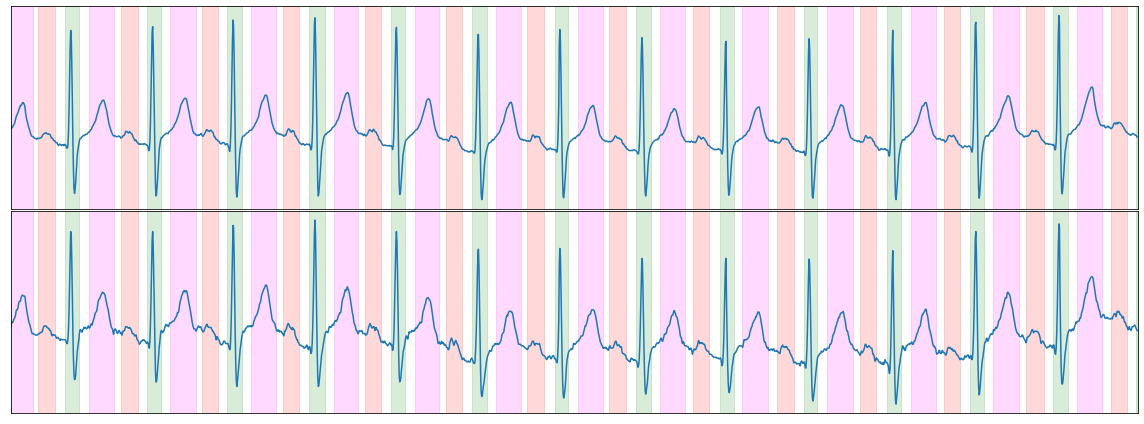

In [91]:
f,ax = plt.subplots(nrows=2,figsize=(16,6))

on = 120000
off = on + 2048

[sak.visualization.signal.segmentation(signal[i,on:off],segmentation[:,on:off],fig=f,ax=ax[i]) for i in range(2)]
[ax[i].set_xlim([0,2048]) for i in range(2)]
[ax[i].set_xticks([]) for i in range(2)]
[ax[i].set_yticks([]) for i in range(2)]
f.tight_layout()
f.subplots_adjust(wspace=0.01,hspace=0.01)